In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()
import warnings

warnings.filterwarnings("ignore")
import logging

import shap
from IPython import display
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    train_test_split,
)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

logging.getLogger("kedro.ipython").disabled = True

logging.getLogger("kedro.io.data_catalog").disabled = True

%load_ext kedro.ipython
warnings.filterwarnings("ignore")
display.clear_output()
pd.set_option("display.max_rows", 500)

# Dataset Loading

In [2]:
df = catalog.load("depression_synthetic_cleaned")
df_real = catalog.load("depression_real_cleaned")
df.info()

                    INFO     Loading data from depression_synthetic_cleaned (CSVDataset)...     ]8;id=635322;file://C:\Users\divya\miniconda3\envs\mlops\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=407671;file://C:\Users\divya\miniconda3\envs\mlops\lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

[11/29/24 03:49:59] INFO     Loading data from depression_real_cleaned (CSVDataset)...          ]8;id=842857;file://C:\Users\divya\miniconda3\envs\mlops\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=428945;file://C:\Users\divya\miniconda3\envs\mlops\lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140602 entries, 0 to 140601
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140602 non-null  object 
 1   Gender                                 140602 non-null  object 
 2   Age                                    140602 non-null  float64
 3   City                                   140602 non-null  object 
 4   Working Professional or Student        140602 non-null  object 
 5   Profession                             140602 non-null  object 
 6   Academic Pressure                      140602 non-null  float64
 7   Work Pressure                          140602 non-null  float64
 8   CGPA                                   140602 non-null  float64
 9   Study Satisfaction                     140602 non-null  float64
 10  Job Satisfaction                       140602 non-null  

In [3]:
print(df.isnull().sum())
print("-" * 50)
print(df_real.isnull().sum())

Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64
--------------------------------------------------
Name                                     0
Gender                                   0
Age                              

In [4]:
print(df.nunique().sort_values())
print("-" * 50)
print(df.nunique().sort_values())

Gender                                     2
Working Professional or Student            2
Have you ever had suicidal thoughts ?      2
Family History of Mental Illness           2
Depression                                 2
Dietary Habits                             3
Sleep Duration                             5
Study Satisfaction                         6
Job Satisfaction                           6
Financial Stress                           6
Academic Pressure                          6
Work Pressure                              6
Work/Study Hours                          13
Degree                                    28
City                                      30
Profession                                35
Age                                       43
CGPA                                     332
Name                                     422
dtype: int64
--------------------------------------------------
Gender                                     2
Working Professional or Student     

In [5]:
df.describe(include="object")

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness
count,140602,140602,140602,140602,140602,140602,140602,140602,140602,140602
unique,422,2,30,2,35,5,3,28,2,2
top,Rohan,Male,Kalyan,Working Professional,Other,Less than 5 hours,Moderate,Class 12,No,No
freq,3178,77412,6591,112727,61548,38761,49695,14722,71092,70705


In [6]:
object_cols = [col for col in df.columns if df[col].dtype == "object"]

# Models

## Train with Numerical data only

In [8]:
float_cols = [col for col in df.columns if (df[col].dtype == "float64")]
float_cols


[
    'Age',
    'Academic Pressure',
    'Work Pressure',
    'CGPA',
    'Study Satisfaction',
    'Job Satisfaction',
    'Work/Study Hours',
    'Financial Stress'
]

In [9]:
df_X = df[float_cols]
df_y = df["Depression"]
print(df_X.columns)
print("-" * 50)
df_real_X = df_real[float_cols]
df_real_y = df_real["Depression"]
print(df_real_X.columns)

Index(['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress'],
      dtype='object')
--------------------------------------------------
Index(['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress'],
      dtype='object')


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, shuffle=True, test_size=0.3, random_state=42
)

## Logistic Regression

### Train

In [11]:
# Train
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict on val
y_preds = clf.predict(X_test)
print(
    f"Accuracy of logistic regression classifier on validation set: {clf.score(X_test, y_test):.2f}"
)

# Evaluate the model on test set
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_preds))

print("-" * 75)

# Predict on real world data
y_preds_real = clf.predict(df_real_X)
print(
    f"Accuracy of logistic regression classifier on real world dataset: {clf.score(df_real_X, df_real_y):.2f}"
)

# Evaluate the model on real world data
accuracy = accuracy_score(df_real_y, y_preds_real)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_real_y, y_preds_real))

Accuracy of logistic regression classifier on validation set: 0.92
Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     34505
           1       0.79      0.74      0.77      7676

    accuracy                           0.92     42181
   macro avg       0.87      0.85      0.86     42181
weighted avg       0.92      0.92      0.92     42181

---------------------------------------------------------------------------
Accuracy of logistic regression classifier on real world dataset: 0.90
Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2101
           1       0.76      0.60      0.67       455

    accuracy                           0.90      2556
   macro avg       0.84      0.78      0.80      2556
weighted avg       0.89      0.90      0.89      2556



### Coefficients

In [12]:
pd.DataFrame({"coeff": clf.coef_[0]}, index=df_X.columns)

,coeff
Age,-0.165290
Academic Pressure,0.866901
Work Pressure,0.632101
CGPA,0.032063
Study Satisfaction,-0.252293
Job Satisfaction,-0.520366
Work/Study Hours,0.132053
Financial Stress,0.569887


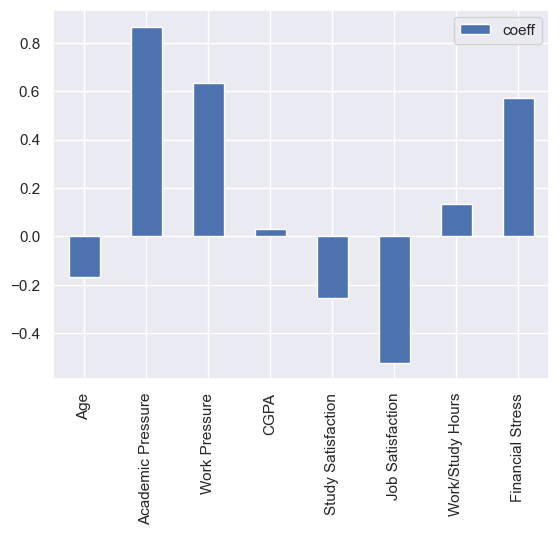

In [13]:
pd.DataFrame({"coeff": clf.coef_[0]}, index=df_X.columns).plot(kind="bar")
plt.show()

### Confusion Matrix on val data

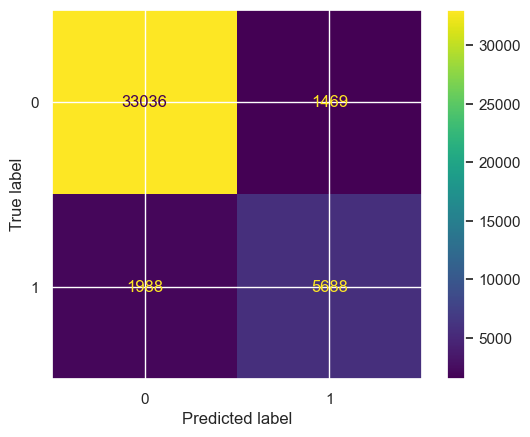

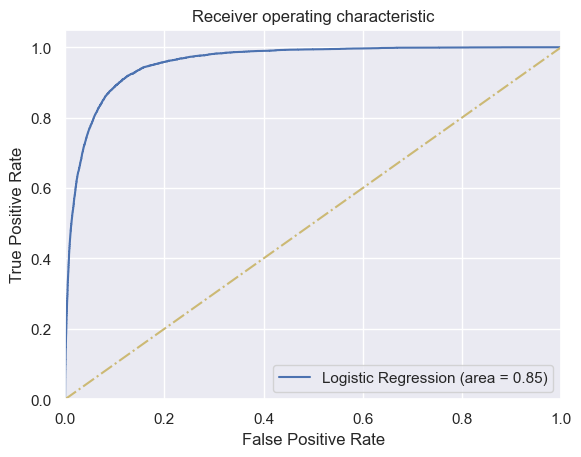

In [14]:
# Comfusion Matrix on val data
cm_np = confusion_matrix(y_test.tolist(), y_preds.tolist())
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm_np, display_labels=[0, 1]
)
cm_display.plot()
plt.show()

# ROC Curve
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "y-.")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix and ROC-AUC curve on real world data

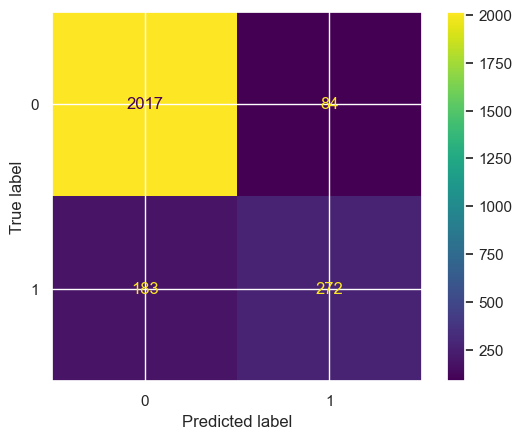

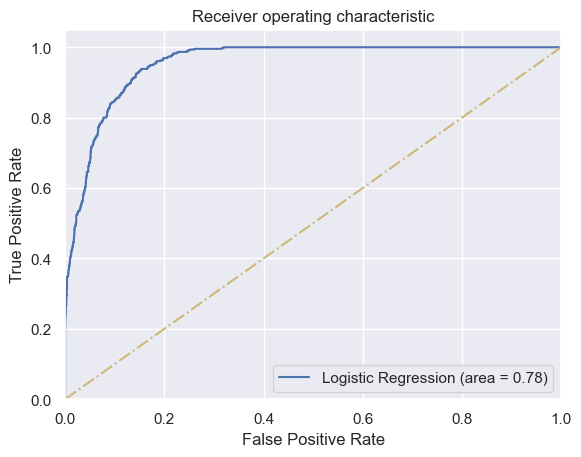

In [15]:
# Comfusion Matrix on val data
cm_np = confusion_matrix(df_real_y.tolist(), y_preds_real.tolist())
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm_np, display_labels=[0, 1]
)
cm_display.plot()
plt.show()

# ROC Curve
logit_roc_auc = roc_auc_score(df_real_y, clf.predict(df_real_X))
fpr, tpr, thresholds = roc_curve(df_real_y, clf.predict_proba(df_real_X)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "y-.")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [16]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on val
y_preds = clf.predict(X_test)
print(f"Accuracy of RF classifier on validation set: {clf.score(X_test, y_test):.2f}")

# Evaluate the model on test set
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_preds))

print("-" * 75)

# Predict on real world data
y_preds_real = clf.predict(df_real_X)
print(
    f"Accuracy of RF classifier on real world dataset: {clf.score(df_real_X, df_real_y):.2f}"
)

# Evaluate the model on real world data
accuracy = accuracy_score(df_real_y, y_preds_real)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_real_y, y_preds_real))

Accuracy of RF classifier on validation set: 0.91
Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     34505
           1       0.75      0.73      0.74      7676

    accuracy                           0.91     42181
   macro avg       0.84      0.84      0.84     42181
weighted avg       0.91      0.91      0.91     42181

---------------------------------------------------------------------------
Accuracy of RF classifier on real world dataset: 0.90
Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2101
           1       0.73      0.66      0.69       455

    accuracy                           0.90      2556
   macro avg       0.83      0.80      0.82      2556
weighted avg       0.89      0.90      0.89      2556



In [17]:
pd.DataFrame({"coeff": clf.feature_importances_}, index=df_X.columns)

,coeff
Age,0.326986
Academic Pressure,0.157021
Work Pressure,0.094374
CGPA,0.112631
Study Satisfaction,0.047443
Job Satisfaction,0.076124
Work/Study Hours,0.106080
Financial Stress,0.079341


<Axes: >

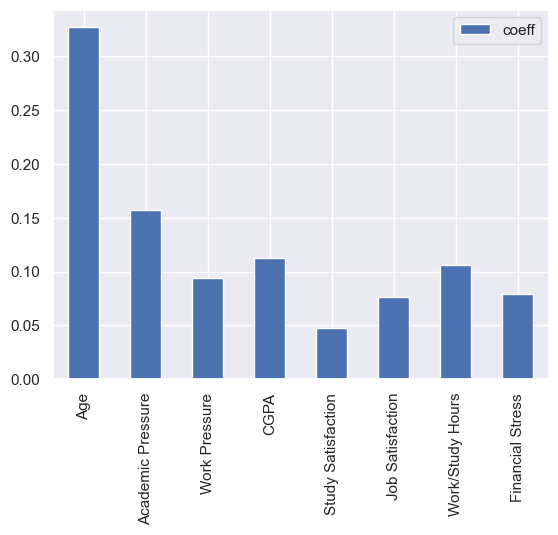

In [18]:
pd.DataFrame({"coeff": clf.feature_importances_}, index=df_X.columns).plot(kind="bar")

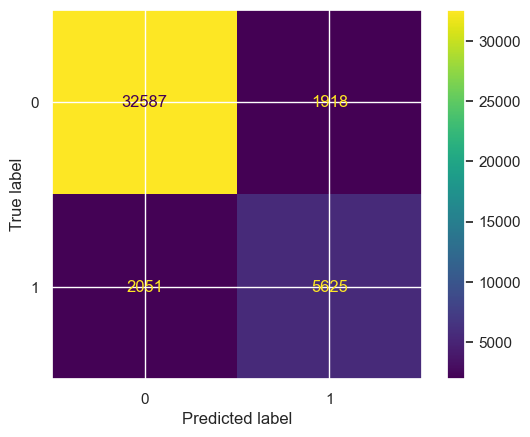

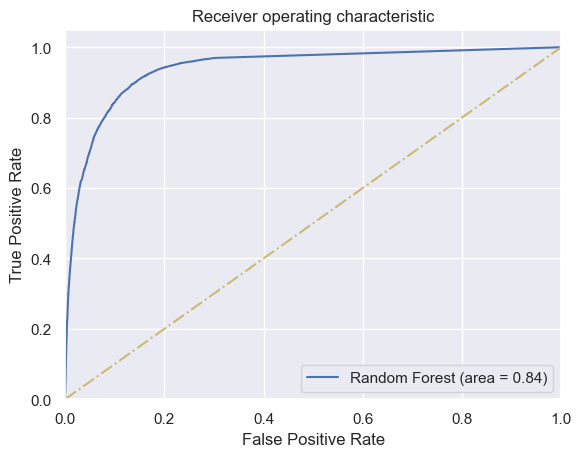

In [19]:
# Comfusion Matrix on val data
cm_np = confusion_matrix(y_test.tolist(), y_preds.tolist())
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm_np, display_labels=[0, 1]
)
cm_display.plot()
plt.show()

# ROC Curve
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Random Forest (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "y-.")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

## Decision Tree

In [20]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train, y_train)

# Predict on val
y_preds = clf.predict(X_test)
print(f"Accuracy of DT classifier on validation set: {clf.score(X_test, y_test):.2f}")

# Evaluate the model on test set
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_preds))

print("-" * 75)

# Predict on real world data
y_preds_real = clf.predict(df_real_X)
print(
    f"Accuracy of DT classifier on real world dataset: {clf.score(df_real_X, df_real_y):.2f}"
)

# Evaluate the model on real world data
accuracy = accuracy_score(df_real_y, y_preds_real)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_real_y, y_preds_real))

Accuracy of DT classifier on validation set: 0.91
Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     34505
           1       0.76      0.76      0.76      7676

    accuracy                           0.91     42181
   macro avg       0.85      0.85      0.85     42181
weighted avg       0.91      0.91      0.91     42181

---------------------------------------------------------------------------
Accuracy of DT classifier on real world dataset: 0.90
Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2101
           1       0.75      0.67      0.71       455

    accuracy                           0.90      2556
   macro avg       0.84      0.81      0.83      2556
weighted avg       0.90      0.90      0.90      2556



In [21]:
def explain_dt_output(clf, data, sample_id_in_data):
    node_indicator = clf.decision_path(data)
    leaf_id = clf.apply(data)

    sample_id = sample_id_in_data

    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]
    print("\nVisited Node Indices:", node_index)

    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    values = clf.tree_.value

    print("Leaf ID: ", leaf_id[sample_id])
    print(f"Rules used to predict sample {sample_id}:\n")

    for node_id in node_index:
        # continue if leaf
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if data.iloc[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            f"decision node {node_id} : ({data.columns[feature[node_id]]} = {data.iloc[sample_id, feature[node_id]]}) "
            f"{threshold_sign} {threshold[node_id]})"
        )

In [22]:
explain_dt_output(clf, df_real_X, 0)


Visited Node Indices: [  0 254 255 256 257 258 266 267 269]
Leaf ID:  269
Rules used to predict sample 0:

decision node 0 : (Age = 37) > 33.5)
decision node 254 : (Academic Pressure = 0.0) <= 2.5)
decision node 255 : (Age = 37) <= 43.5)
decision node 256 : (Work Pressure = 2.0) <= 4.5)
decision node 257 : (Financial Stress = 2) <= 4.5)
decision node 258 : (Job Satisfaction = 4.0) > 2.5)
decision node 266 : (Work Pressure = 2.0) <= 3.5)
decision node 267 : (Age = 37) > 34.5)


## XGBoost

In [23]:
# Initialize
# clf = XGBClassifier(
#     objective='multi:softmax',  # For multiclass classification
#     num_class=2,               # Number of classes
#     max_depth=4,               # Maximum depth of a tree
#     learning_rate=0.1,         # Step size shrinkage
#     n_estimators=100,          # Number of boosting rounds
#     random_state=42
# )

clf = XGBClassifier(random_state=42)

# Train
clf.fit(X_train, y_train)

# Make predictions on test set
y_preds = clf.predict(X_test)
print(f"Accuracy of XGB classifier on validation set: {clf.score(X_test, y_test):.2f}")

# Evaluate the model on test set
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_preds))

print("-" * 75)

# Predict on real world data
y_preds_real = clf.predict(df_real_X)
print(
    f"Accuracy of DT classifier on real world dataset: {clf.score(df_real_X, df_real_y):.2f}"
)

# Evaluate the model on real world data
accuracy = accuracy_score(df_real_y, y_preds_real)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_real_y, y_preds_real))

Accuracy of XGB classifier on validation set: 0.92
Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     34505
           1       0.78      0.75      0.77      7676

    accuracy                           0.92     42181
   macro avg       0.86      0.85      0.86     42181
weighted avg       0.92      0.92      0.92     42181

---------------------------------------------------------------------------
Accuracy of DT classifier on real world dataset: 0.92
Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2101
           1       0.81      0.68      0.74       455

    accuracy                           0.92      2556
   macro avg       0.87      0.82      0.84      2556
weighted avg       0.91      0.92      0.91      2556



In [24]:
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_train)

<IPython.core.display.HTML object>

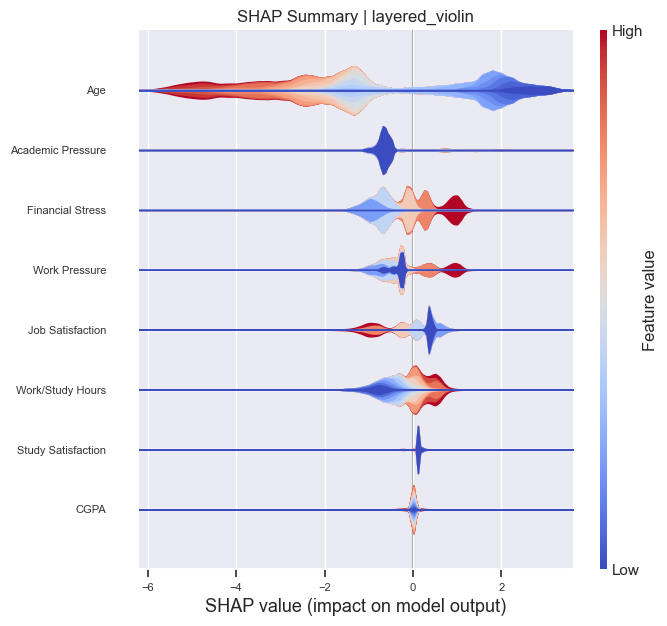

In [25]:
shap.plots.violin(shap_values, plot_type="layered_violin", show=False)
fig, ax = plt.gcf(), plt.gca()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.tick_params(labelsize=8)
ax.set_title("SHAP Summary | layered_violin", fontsize=12)
plt.show()

In [26]:
shap.plots.force(shap_values[0])

<shap.plots._force.AdditiveForceVisualizer object at 0x000001C07A013CD0>

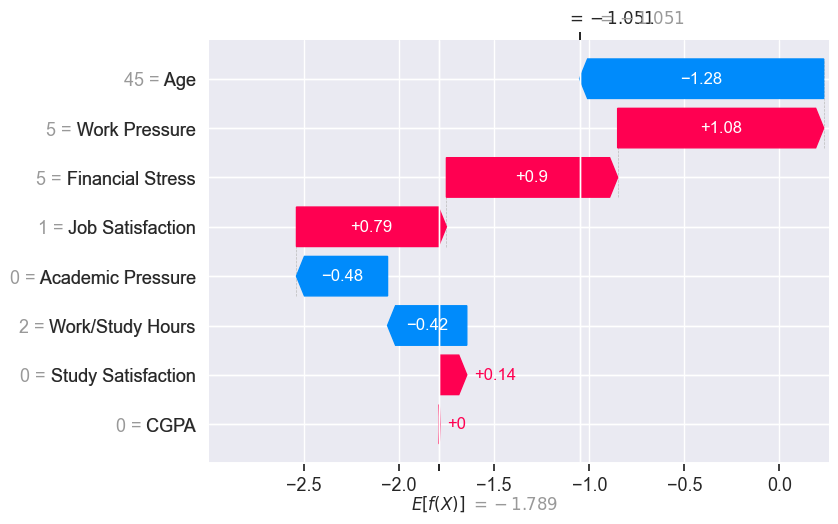

In [27]:
shap.plots.waterfall(shap_values[0], max_display=23, show=True)

In [28]:
# shap.plots.heatmap(shap_values, max_display = 23, show = False)
# fig, ax = plt.gcf(), plt.gca()
# fig.set_figheight(5)
# fig.set_figwidth(10)
# ax.tick_params(labelsize=8)
# cb_ax = fig.axes[1]
# cb_ax.tick_params(labelsize=8)
# cb_ax.set_ylabel("Shap value", fontsize=8)
# ax.set_title("Shap plots HeatMap", fontsize=12)
# plt.show()